In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
diabetes= pd.read_csv('/content/drive/MyDrive/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning Data

In [ ]:
#how many rows
len(diabetes)

768

In [ ]:
#count how many zeros's are in each column
(diabetes==0).sum()


,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [ ]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#get rid of rows where glucose=0, bloodpressure=0, BMI=0
diabetes=diabetes.loc[diabetes['Glucose']!=0]
diabetes=diabetes.loc[diabetes['BloodPressure']!=0]
diabetes=diabetes.loc[diabetes['BMI']!=0]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [ ]:
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']
print(X.shape)

(724, 8)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify= y_resampled)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#before cross validation
logreg = LogisticRegression(solver='saga', max_iter=5000)
logreg.fit(X_train_scaled, y_train)
y_pred_LR = logreg.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_LR))

0.743859649122807


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np

metrics = {"accuracy_LR": [], "precision_LR": [], "recall_LR": [], "f1_score_LR": [], "roc_auc_LR": [],"MSE_LR": [], "sensitivity_LR":[],"specificity_LR":[]}
#
# repeat logistic regression 20 times
for i in range(20):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3,stratify=y_resampled, random_state=i)
    y_train= np.array(y_train)

    #scale data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #logistic regression
    logreg = LogisticRegression(solver='saga', max_iter=5000, random_state=i)
    # Cross-validation loop
    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index],y_train[test_index]

        logreg.fit(X_train_fold, y_train_fold)
    #predict
        y_pred_LR = logreg.predict(X_val_fold)
        y_proba_LR = logreg.predict_proba(X_val_fold)[:, 1]
    # Confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred_LR)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_LR))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_LR, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_LR))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_LR))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_LR))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_LR))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)
    #metrics
    metrics["accuracy_LR"].append(np.mean(fold_metrics["accuracy"]))
    metrics["precision_LR"].append(np.mean(fold_metrics["precision"]))
    metrics["recall_LR"].append(np.mean(fold_metrics["recall"]))
    metrics["f1_score_LR"].append(np.mean(fold_metrics["f1_score"]))
    metrics["roc_auc_LR"].append(np.mean(fold_metrics["roc_auc"]))
    metrics["MSE_LR"].append(np.mean(fold_metrics["MSE"]))
    metrics["sensitivity_LR"].append(np.mean(fold_metrics["sensitivity"]))
    metrics["specificity_LR"].append(np.mean(fold_metrics["specificity"]))

avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}
print(avg_metrics)


{'accuracy_LR': 0.7514285714285713, 'precision_LR': 0.7638032525570142, 'recall_LR': 0.730922659430122, 'f1_score_LR': 0.7456162671085046, 'roc_auc_LR': 0.83880144730891, 'MSE_LR': 0.24857142857142858, 'sensitivity_LR': 0.730922659430122, 'specificity_LR': 0.771951605608322}


In [ ]:
from sklearn.metrics import roc_curve
#average fpr_LR , tpr_LR and threshold_LR for 20 iterations
fpr_LR, tpr_LR, threshold_LR = roc_curve(y_val_fold, y_proba_LR)
roc_auc_LR= roc_auc_score(y_val_fold, y_proba_LR)
print(roc_auc_LR)

0.8093622795115332


## KNN

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

In [ ]:
def confusion_table(y_pred, y_true):

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

for K in range(1, 9):
    knn = KNeighborsClassifier(n_neighbors=K)
    # Fit the model on the training set
    knn.fit(X_train_scaled, y_train)
    # Predict on the test set
    knn_pred = knn.predict(X_test_scaled)
    # Get the confusion matrix
    C = confusion_table(knn_pred, y_test)
    pred = C.loc[1].sum()  # Total predicted 'Yes' (now represented by 1)
    positive_thyroid = C.loc[1, 1]  # True Positives (correctly predicted 'Yes')
    accuracy = positive_thyroid / pred if pred > 0 else 0  # Avoid division by zero

    # Print the results for each value of K
    templ = (
        "K={0:d}: # Predicted to have Diabetes: {1:>2}, "
        "# Correctly predicted Diabetes: {2:d}, Accuracy: {3:.1%}"
    )
    print(templ.format(K, pred, positive_thyroid, accuracy))

K=1: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 118, Accuracy: 82.5%
K=2: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 98, Accuracy: 68.5%
K=3: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 127, Accuracy: 88.8%
K=4: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 110, Accuracy: 76.9%
K=5: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 120, Accuracy: 83.9%
K=6: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 113, Accuracy: 79.0%
K=7: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 123, Accuracy: 86.0%
K=8: # Predicted to have Diabetes: 143, # Correctly predicted Diabetes: 114, Accuracy: 79.7%


In [ ]:
n_neighbors = 7
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train_scaled, y_train)
y_pred_KNN = knn.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_KNN))

0.7684210526315789


In [ ]:
metrics_knn = {
    "accuracy_KNN": [],
    "precision_KNN": [],
    "recall_KNN": [],
    "f1_score_KNN": [],
    "roc_auc_KNN": [],
    "MSE_KNN": [],
    "sensitivity_KNN":[],"specificity_KNN":[]
}
n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
# Repeat the process 20 times
for i in range(20):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=i)
    y_train= np.array(y_train)
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Train
        knn.fit(X_train_fold, y_train_fold)
    # Predict
        y_pred_KNN = knn.predict(X_val_fold)
        y_proba_KNN = knn.predict_proba(X_val_fold)[:, 1]
    #confusion mattrix
        cm = confusion_matrix(y_val_fold, y_pred_KNN)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    # Collect metrics for the current fold
        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_KNN))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_KNN, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_KNN))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_KNN))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_KNN))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_KNN))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)

    # Metrics
    metrics_knn["accuracy_KNN"].append(np.mean(fold_metrics["accuracy"]))
    metrics_knn["precision_KNN"].append(np.mean(fold_metrics["precision"]))
    metrics_knn["recall_KNN"].append(np.mean(fold_metrics["recall"]))
    metrics_knn["f1_score_KNN"].append(np.mean(fold_metrics["f1_score"]))
    metrics_knn["roc_auc_KNN"].append(np.mean(fold_metrics["roc_auc"]))
    metrics_knn["MSE_KNN"].append(np.mean(fold_metrics["MSE"]))
    metrics_knn["sensitivity_KNN"].append(np.mean(fold_metrics["sensitivity"]))
    metrics_knn["specificity_KNN"].append(np.mean(fold_metrics["specificity"]))


# Calculate average metrics
avg_metrics_knn = {metric: np.mean(scores) for metric, scores in metrics_knn.items()}
print(avg_metrics_knn)


{'accuracy_KNN': 0.7730827067669173, 'precision_KNN': 0.7474244953608774, 'recall_KNN': 0.8280099502487562, 'f1_score_KNN': 0.7846117875905101, 'roc_auc_KNN': 0.8276300316598825, 'MSE_KNN': 0.22691729323308266, 'sensitivity_KNN': 0.8280099502487562, 'specificity_KNN': 0.7182767978290366}


In [ ]:
#average fpr_KNN , tpr_KNN and threshold_KNN for 20 iterations
fpr_KNN, tpr_KNN, threshold_KNN = roc_curve(y_val_fold, y_proba_KNN)
roc_auc_KNN = roc_auc_score(y_val_fold, y_proba_KNN)
print(roc_auc_KNN)

0.8403437358661239


#Deision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [ ]:
tree= DTC(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [ ]:
accuracy_score(y_test, tree.predict(X_test_scaled))

0.712280701754386

In [ ]:
from sklearn.metrics import log_loss
resid_dev= np.sum(log_loss(y_test, tree.predict_proba(X_test_scaled)))
print(resid_dev)

1.2299352968359287


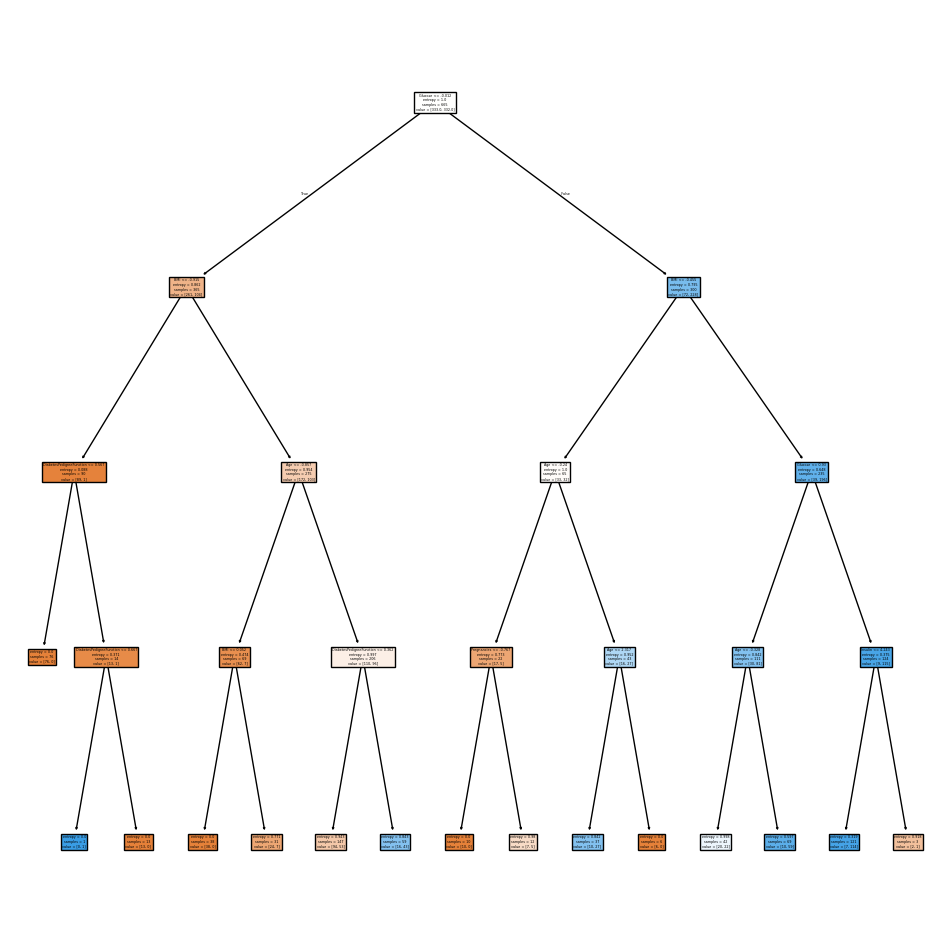

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(tree, ax=ax, feature_names=X.columns, filled=True)
plt.show()

In [ ]:
tree2= DTC(criterion='entropy', max_depth=4, random_state=0)
tree2.fit(X_train_scaled, y_train)
accuracy_score(y_test, tree2.predict(X_test_scaled))

0.712280701754386

In [ ]:
from sklearn.model_selection import KFold
ccp_path= tree2.cost_complexity_pruning_path(X_train_scaled, y_train)
kfold= KFold(10, random_state=None, shuffle= True)

In [ ]:
from sklearn.model_selection import GridSearchCV
grid= GridSearchCV(tree2, {'ccp_alpha': ccp_path['ccp_alphas']},
                  cv=kfold, scoring='accuracy',
                  refit=True)
grid.fit(X_train_scaled, y_train)
grid.best_score_

0.7579149706015377

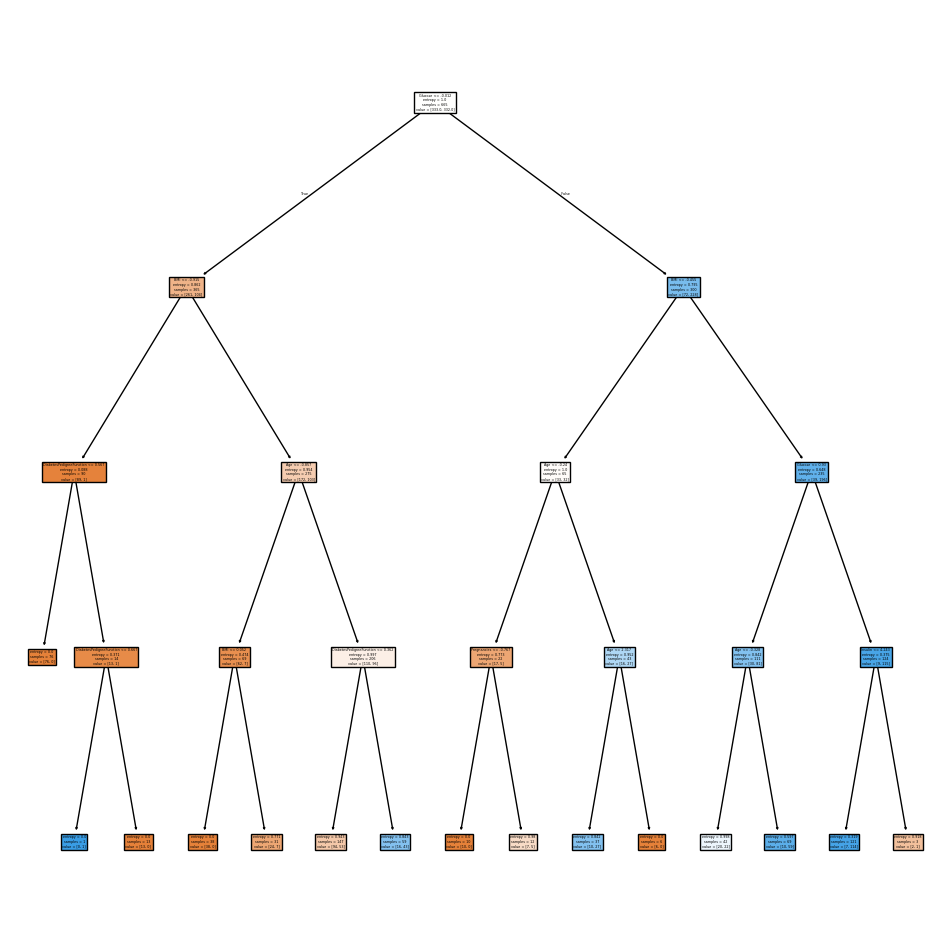

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(tree2, ax=ax, feature_names=X.columns, filled=True)
plt.show()

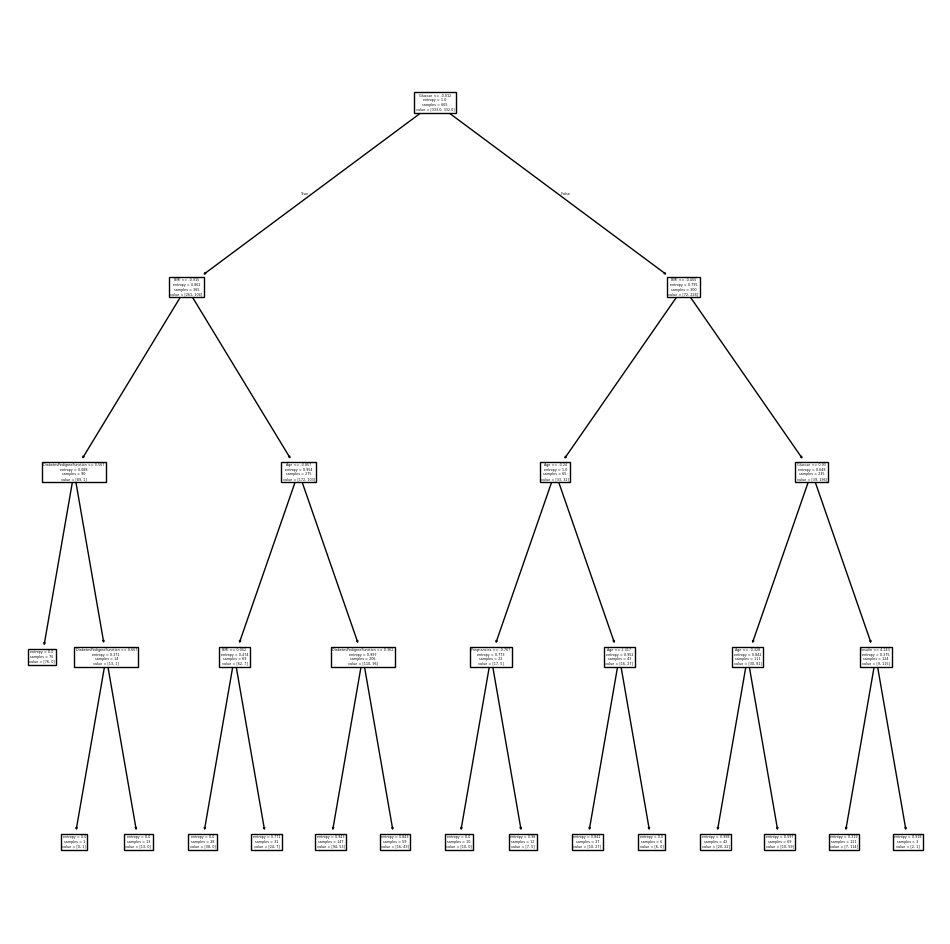

In [ ]:
ax2= plt.subplots(figsize=(12, 12))[1]
best_tree = grid.best_estimator_
plot_tree(best_tree, feature_names=X.columns, ax=ax2)
plt.show()

In [ ]:
resid_dev2= np.sum(log_loss(y_test, best_tree.predict_proba(X_test_scaled)))
print(resid_dev2)

1.2299352968359287


Best tree does not improve the model by much in accuracy or residual score, so we will keep original tree model.

In [ ]:
tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_tree))

0.712280701754386


In [ ]:
#Do model tree 20 times
metrics_tree = {
    "accuracy_tree": [],
    "precision_tree": [],
    "recall_tree": [],
    "f1_score_tree": [],
    "roc_auc_tree": [],
    "MSE_tree": [],
    "sensitivity_tree":[],"specificity_tree":[]
}
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=i)
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train= np.array(y_train)

    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
        # Train
        tree.fit(X_train_fold, y_train_fold)
    # Predict
        y_pred_tree = tree.predict(X_val_fold)
        y_proba_tree = tree.predict_proba(X_val_fold)[:, 1]
    # confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred_tree)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
         # Collect metrics for the current fold
        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_tree))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_tree, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_tree))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_tree))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_tree))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_tree))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)


    metrics_tree["accuracy_tree"].append(np.mean(fold_metrics["accuracy"]))
    metrics_tree["precision_tree"].append(np.mean(fold_metrics["precision"]))
    metrics_tree["recall_tree"].append(np.mean(fold_metrics["recall"]))
    metrics_tree["f1_score_tree"].append(np.mean(fold_metrics["f1_score"]))
    metrics_tree["roc_auc_tree"].append(np.mean(fold_metrics["roc_auc"]))
    metrics_tree["MSE_tree"].append(np.mean(fold_metrics["MSE"]))
    metrics_tree["sensitivity_tree"].append(np.mean(fold_metrics["sensitivity"]))
    metrics_tree["specificity_tree"].append(np.mean(fold_metrics["specificity"]))

# Calculate average metrics
avg_metrics_tree = {metric: np.mean(scores) for metric, scores in metrics_tree.items()}
print(avg_metrics_tree)

{'accuracy_tree': 0.7351127819548872, 'precision_tree': 0.7264852527785786, 'recall_tree': 0.7671528720036183, 'f1_score_tree': 0.7416911082887732, 'roc_auc_tree': 0.804369063772049, 'MSE_tree': 0.2648872180451127, 'sensitivity_tree': 0.7671528720036183, 'specificity_tree': 0.7030122116689281}


In [ ]:
#average fpr_tree , tpr_tree and threshold_tree for 20 iterations
fpr_tree, tpr_tree, threshold_tree = roc_curve(y_val_fold, y_proba_tree)
roc_auc_tree = roc_auc_score(y_val_fold, y_proba_tree)
print(roc_auc_tree)

0.819538670284939


## Naive Bayes

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
param_grid = {'var_smoothing': np.logspace(-12, -7, 6)}
grid_search = GridSearchCV(GaussianNB(), param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_resampled, y_resampled)
best_smoothing = grid_search.best_params_['var_smoothing']
nb = GaussianNB(var_smoothing=best_smoothing)

In [ ]:
nb = GaussianNB(var_smoothing=best_smoothing)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_test, y_pred_nb))

0.712280701754386


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define metrics dictionary
metrics_nb = {
    "accuracy_nb": [],
    "precision_nb": [],
    "recall_nb": [],
    "f1_score_nb": [],
    "roc_auc_nb": [],
    "MSE_nb": [],
    "sensitivity_nb": [],
    "specificity_nb": []
}

# Initialize Naive Bayes model
nb = GaussianNB(var_smoothing=best_smoothing)
scaler = StandardScaler()

# Stratified K-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Repeat 20 times
for i in range(20):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=i)
    y_train = np.array(y_train)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    # Cross-validation loop
    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

        # Train Naive Bayes
        nb.fit(X_train_fold, y_train_fold)
        y_pred_nb = nb.predict(X_val_fold)
        y_proba_nb = nb.predict_proba(X_val_fold)[:, 1]

        # Confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred_nb)
        if cm.shape == (2, 2):  # Only proceed if it's a 2x2 matrix
            TN, FP, FN, TP = cm.ravel()
            sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
            specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        else:
            TN, FP, FN, TP = 0, 0, 0, 0  # Handle cases where the model doesn't predict both classes
            sensitivity = 0
            specificity = 0

        # Collect fold metrics
        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_nb))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_nb, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_nb))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_nb))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_nb))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_nb))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)

    # Collect average metrics across folds
    metrics_nb["accuracy_nb"].append(np.mean(fold_metrics["accuracy"]))
    metrics_nb["precision_nb"].append(np.mean(fold_metrics["precision"]))
    metrics_nb["recall_nb"].append(np.mean(fold_metrics["recall"]))
    metrics_nb["f1_score_nb"].append(np.mean(fold_metrics["f1_score"]))
    metrics_nb["roc_auc_nb"].append(np.mean(fold_metrics["roc_auc"]))
    metrics_nb["MSE_nb"].append(np.mean(fold_metrics["MSE"]))
    metrics_nb["sensitivity_nb"].append(np.mean(fold_metrics["sensitivity"]))
    metrics_nb["specificity_nb"].append(np.mean(fold_metrics["specificity"]))

# Calculate and print the average metrics across 20 iterations
avg_metrics_nb = {metric: np.mean(scores) for metric, scores in metrics_nb.items()}
print(avg_metrics_nb)


{'accuracy_nb': 0.7326973684210526, 'precision_nb': 0.7599687699812472, 'recall_nb': 0.6827631578947368, 'f1_score_nb': 0.7181917256128186, 'roc_auc_nb': 0.820895083102493, 'MSE_nb': 0.26730263157894735, 'sensitivity_nb': 0.6827631578947368, 'specificity_nb': 0.7826315789473686}


In [ ]:
#average fpr_nb , tpr_nb and threshold_nb for 20 iterations
fpr_nb, tpr_nb, threshold_nb = roc_curve(y_val_fold, y_proba_nb)
roc_auc_nb = roc_auc_score(y_val_fold, y_proba_nb)
print(roc_auc_nb)

0.82946675900277


LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_lda))

0.7315789473684211


In [ ]:
#do the same for LDA
metrics_lda = {
    "accuracy_lda": [],
    "precision_lda": [],
    "recall_lda": [],
    "f1_score_lda": [],
    "roc_auc_lda": [],
    "MSE_lda": [],
    "sensitivity_lda":[],"specificity_lda":[]
}
lda = LinearDiscriminantAnalysis()
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=i)
    y_train= np.array(y_train)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

        lda.fit(X_train_fold, y_train_fold)
        y_pred_lda = lda.predict(X_val_fold)
        y_proba_lda = lda.predict_proba(X_val_fold)[:,1]
        cm = confusion_matrix(y_val_fold, y_pred_lda)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        # Collect metrics for the current fold
        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_lda))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_lda, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_lda))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_lda))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_lda))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_lda))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)

    metrics_lda["accuracy_lda"].append(np.mean(fold_metrics["accuracy"]))
    metrics_lda["precision_lda"].append(np.mean(fold_metrics["precision"]))
    metrics_lda["recall_lda"].append(np.mean(fold_metrics["recall"]))
    metrics_lda["f1_score_lda"].append(np.mean(fold_metrics["f1_score"]))
    metrics_lda["roc_auc_lda"].append(np.mean(fold_metrics["roc_auc"]))
    metrics_lda["MSE_lda"].append(np.mean(fold_metrics["MSE"]))
    metrics_lda["sensitivity_lda"].append(np.mean(fold_metrics["sensitivity"]))
    metrics_lda["specificity_lda"].append(np.mean(fold_metrics["specificity"]))

avg_metrics_lda = {metric: np.mean(scores) for metric, scores in metrics_lda.items()}
print(avg_metrics_lda)

{'accuracy_lda': 0.7476691729323308, 'precision_lda': 0.7652724144621688, 'recall_lda': 0.7170262324739938, 'f1_score_lda': 0.7389005947774661, 'roc_auc_lda': 0.8400949796472185, 'MSE_lda': 0.25233082706766913, 'sensitivity_lda': 0.7170262324739938, 'specificity_lda': 0.7784441429217548}


In [ ]:
#average fpr_lda , tpr_lda and threshold_lda for 20 iterations
fpr_lda, tpr_lda, threshold_lda = roc_curve(y_val_fold, y_proba_lda)
roc_auc_lda = roc_auc_score(y_val_fold, y_proba_lda)
print(roc_auc_lda)

0.8487109905020352


## Support Vector Machines

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_svm))

0.7368421052631579


In [ ]:
#Same for Support Vector Machines

metrics_svm = {
    "accuracy_svm": [],
    "precision_svm": [],
    "recall_svm": [],
    "f1_score_svm": [],
    "roc_auc_svm": [],
    "MSE_svm": [],
    "sensitivity_svm":[],"specificity_svm":[]
}
svm = SVC(kernel='linear', probability=True)
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=i)
    y_train= np.array(y_train)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    fold_metrics = {
        "accuracy": [], "precision": [], "recall": [], "f1_score": [], "roc_auc": [], "MSE": [], "sensitivity": [], "specificity": []
    }

    for train_index, test_index in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

        svm.fit(X_train_fold, y_train_fold)
        y_pred_svm = svm.predict(X_val_fold)
        y_proba_svm = svm.predict_proba(X_val_fold)[:,1]
        cm = confusion_matrix(y_val_fold, y_pred_svm)
        TN, FP, FN, TP = cm.ravel()
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_svm))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_svm, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_svm))
        fold_metrics["f1_score"].append(f1_score(y_val_fold, y_pred_svm))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_svm))
        fold_metrics["MSE"].append(mean_squared_error(y_val_fold, y_pred_svm))
        fold_metrics["sensitivity"].append(sensitivity)
        fold_metrics["specificity"].append(specificity)

      # Append the average metrics of the current run to the overall metrics
    metrics_svm["accuracy_svm"].append(np.mean(fold_metrics["accuracy"]))
    metrics_svm["precision_svm"].append(np.mean(fold_metrics["precision"]))
    metrics_svm["recall_svm"].append(np.mean(fold_metrics["recall"]))
    metrics_svm["f1_score_svm"].append(np.mean(fold_metrics["f1_score"]))
    metrics_svm["roc_auc_svm"].append(np.mean(fold_metrics["roc_auc"]))
    metrics_svm["MSE_svm"].append(np.mean(fold_metrics["MSE"]))
    metrics_svm["sensitivity_svm"].append(np.mean(fold_metrics["sensitivity"]))
    metrics_svm["specificity_svm"].append(np.mean(fold_metrics["specificity"]))
avg_metrics_svm = {metric: np.mean(scores) for metric, scores in metrics_svm.items()}
print(avg_metrics_svm)

{'accuracy_svm': 0.7495488721804511, 'precision_svm': 0.7618379403247705, 'recall_svm': 0.728441881501583, 'f1_score_svm': 0.7433472899717278, 'roc_auc_svm': 0.8399185888738125, 'MSE_svm': 0.2504511278195488, 'sensitivity_svm': 0.728441881501583, 'specificity_svm': 0.770773405698779}


In [ ]:
#average fpr_svm , tpr_svm and threshold_svm for 20 iterations
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_val_fold, y_proba_svm)
roc_auc_svm = roc_auc_score(y_val_fold, y_proba_svm)
print(roc_auc_svm)

0.8498417005879693


## Compare Models

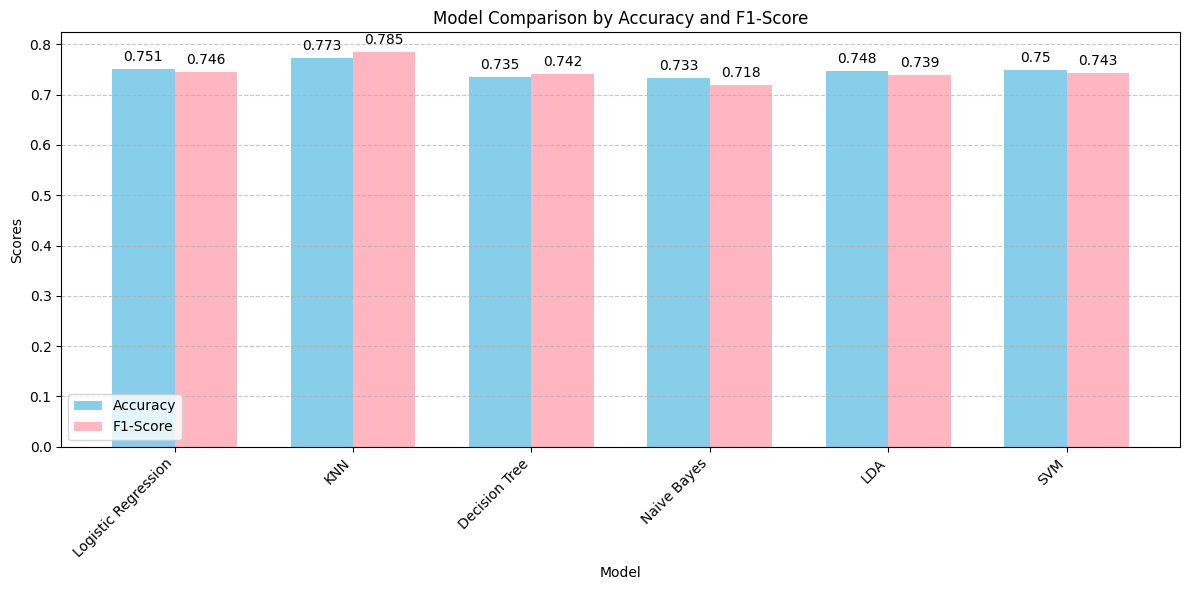

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Naive Bayes', 'LDA', 'SVM']
accuracy = [avg_metrics['accuracy_LR'], avg_metrics_knn['accuracy_KNN'], avg_metrics_tree['accuracy_tree'],
            avg_metrics_nb['accuracy_nb'], avg_metrics_lda['accuracy_lda'], avg_metrics_svm['accuracy_svm']]
f1_scores = [avg_metrics['f1_score_LR'], avg_metrics_knn['f1_score_KNN'], avg_metrics_tree['f1_score_tree'],
             avg_metrics_nb['f1_score_nb'], avg_metrics_lda['f1_score_lda'], avg_metrics_svm['f1_score_svm']]
colors_accuracy = 'skyblue'
colors_f1 = 'lightpink'
bar_width = 0.35
index = np.arange(len(models))
plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, color=colors_accuracy, label='Accuracy')
plt.bar(index + bar_width, f1_scores, bar_width, color=colors_f1, label='F1-Score')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Comparison by Accuracy and F1-Score')
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i in range(len(models)):
    plt.text(i, accuracy[i] + 0.01, str(round(accuracy[i], 3)), ha='center', va='bottom')
    plt.text(i + bar_width, f1_scores[i] + 0.01, str(round(f1_scores[i], 3)), ha='center', va='bottom')
plt.legend(loc='lower left')
plt.show()

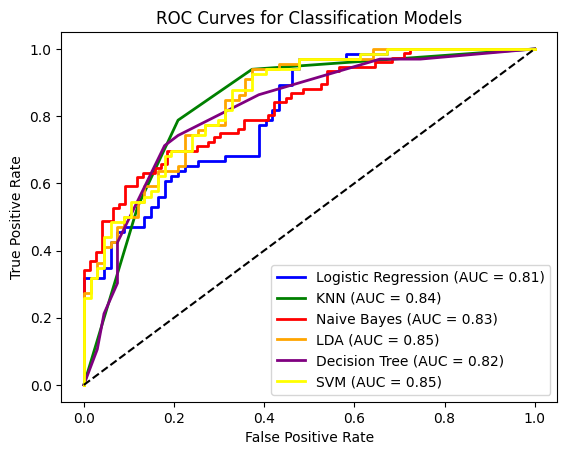

In [ ]:
#use avg_tpr_model , avg_fpr_model and avg_threshold_model to create a ROC curve
plt.figure()
plt.plot(fpr_LR, tpr_LR, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_LR:.2f})')
plt.plot(fpr_KNN, tpr_KNN, color='green', lw=2, label=f'KNN (AUC = {roc_auc_KNN:.2f})')
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_lda, tpr_lda, color='orange', lw=2, label=f'LDA (AUC = {roc_auc_lda:.2f})')
plt.plot(fpr_tree, tpr_tree, color='purple', lw=2, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot(fpr_svm, tpr_svm, color='yellow', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC Curves for Classification Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

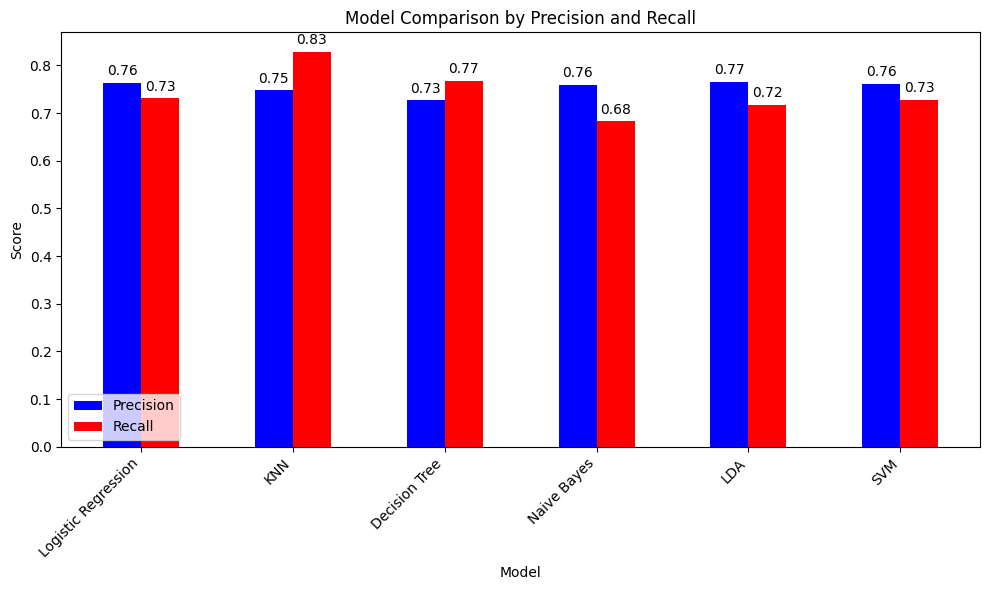

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

precision = [avg_metrics['precision_LR'], avg_metrics_knn['precision_KNN'], avg_metrics_tree['precision_tree'], avg_metrics_nb['precision_nb'], avg_metrics_lda['precision_lda'], avg_metrics_svm['precision_svm']]
recall = [avg_metrics['recall_LR'], avg_metrics_knn['recall_KNN'], avg_metrics_tree['recall_tree'], avg_metrics_nb['recall_nb'], avg_metrics_lda['recall_lda'], avg_metrics_svm['recall_svm']]
barWidth = 0.25
r1 = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Assign the result of plt.bar to precision_bars and recall_bars for later use
precision_bars = plt.bar(r1, precision, barWidth, label='Precision', color='Blue') # Assign the result to precision_bars
recall_bars = plt.bar(r1 + barWidth, recall, barWidth, label='Recall', color='Red')   # Assign the result to recall_bars


plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison by Precision and Recall')
plt.xticks(r1 + barWidth/2, models, rotation=45, ha='right')
plt.legend(loc='lower left')

# Add text labels above the bars for Precision
for bar in precision_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)
# Add text labels above the bars for Recall
for bar in recall_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

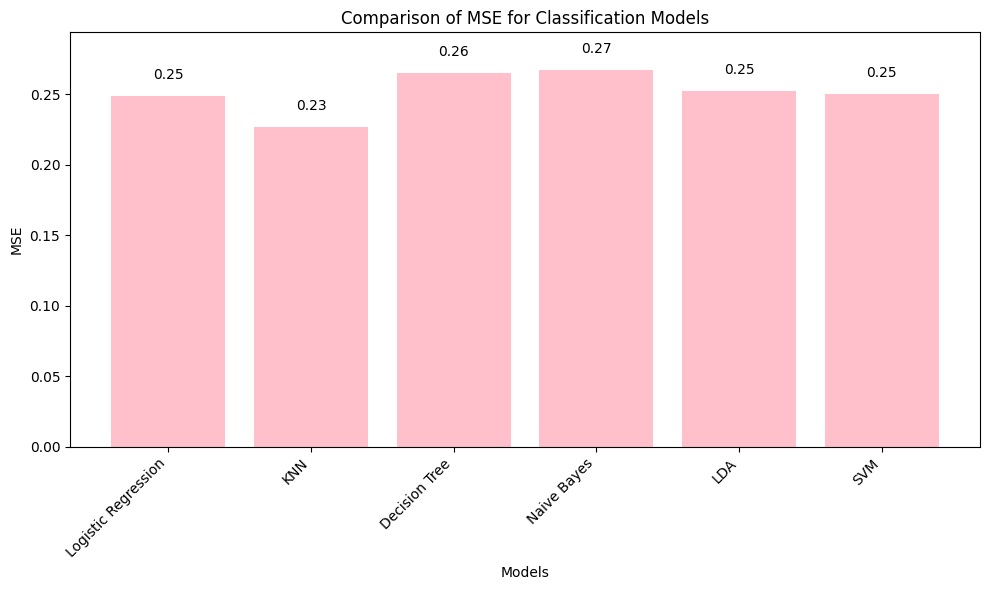

In [ ]:
mse_scores = [avg_metrics['MSE_LR'], avg_metrics_knn['MSE_KNN'], avg_metrics_tree['MSE_tree'],
              avg_metrics_nb['MSE_nb'], avg_metrics_lda['MSE_lda'], avg_metrics_svm['MSE_svm']]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mse_scores, color='pink')
plt.ylim(0, max(mse_scores) + 0.1 * max(mse_scores))
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Comparison of MSE for Classification Models')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()